# Videte Wheel
## Install Requirements

In [1]:
!conda install -y control slycot

Solving environment: done

# All requested packages already installed.



## Videte Wheel Kinematics
### Basic Definitions

In [1]:
import sympy

# Declare Time
t = sympy.symbols('t')

# Declare Functions
y = sympy.Function('y')(t)
θ = sympy.Function('θ')(t)
ρ = sympy.Function('ρ')(t)
φ = sympy.Function('φ')(t)

# Declare Masses
m_ow, m_ow_rot, m_iw, m_iw_rot, m_m = sympy.symbols('m_ow m_owr m_iw m_iwr m_m')

# Declare Dimensions
l_iw_m, r_1, r_2, r_3 = sympy.symbols('l_iwm r_1 r_2 r_3')
l_ow_iw = r_2 - r_1

# Declare Gravity
g = sympy.symbols('g')

In [3]:
# Gear ratio
i_gear = r_2 / r_1

# Linking rotation of outer and inner wheel
φ_iw = φ
φ_ow = (1/i_gear) * φ_iw

ω = φ.diff(t)
ω_iw = ω
ω_ow = φ_ow.diff(t)

In [4]:
# Y positions
y_ow = r_3 + y
y_iw = y_ow - l_ow_iw * sympy.cos(ρ)
y_m = y_iw + l_iw_m * sympy.cos(θ)

# Rotation based x movement
# TODO: Check to be correct
x = r_3 * (φ_ow - ρ)

# X positions
x_ow = x
x_iw = x_ow + l_ow_iw * sympy.sin(ρ)
x_m = x_iw + l_iw_m * sympy.sin(θ)

### State X

In [17]:
state_x = [θ, θ.diff(t), ρ, ρ.diff(t), φ, φ.diff(t)]

state_x

[θ(t),
 Derivative(θ(t), t),
 ρ(t),
 Derivative(ρ(t), t),
 φ(t),
 Derivative(φ(t), t)]

### Potential Energy

In [5]:
V = (m_m * y_m + m_ow * y_ow + m_iw * y_iw) * g

V

g*(m_iw*(r_3 - (-r_1 + r_2)*cos(ρ(t)) + y(t)) + m_m*(l_iwm*cos(θ(t)) + r_3 - (-r_1 + r_2)*cos(ρ(t)) + y(t)) + m_ow*(r_3 + y(t)))

### Kinetic Energy

In [7]:
# Rotating mass inertia
J_ow = (1/2) * m_ow_rot * (r_2**2 + r_3**2)
J_iw = (1/2) * m_iw_rot * r_1**2

# Kinetic energy of rotating cylinder
W_owr = (1/2) * J_ow * ω_ow**2
W_iwr = (1/2) * J_iw * ω_iw**2

# Translational kinetic energy
W_ow = (1/2) * m_ow * (sympy.diff(x_ow, t)**2 + sympy.diff(y_ow, t)**2)
W_iw = (1/2) * m_iw * (sympy.diff(x_iw, t)**2 + sympy.diff(y_iw, t)**2)
W_m = (1/2) * m_m * (sympy.diff(x_m, t)**2 + sympy.diff(y_m, t)**2)

# Dampening (e.g. heat dissipation)
d_ow, d_iw, d_m, d_owr, d_iwr = sympy.symbols(
    'd_ow d_iw d_m d_owr d_iwr')

W_d_ow = sympy.integrate(
    d_ow * (1/2) * (sympy.diff(x_ow, t)**2 + sympy.diff(y_ow, t)**2), t)
W_d_iw = sympy.integrate(d_iw * (1/2) * sympy.diff(ρ, t)**2, t)
W_d_m = sympy.integrate((d_m * (1/2) * sympy.diff(θ, t)**2), t)
W_d_owr = sympy.integrate(d_owr * (1/2) * ω_ow**2, t)
W_d_iwr = sympy.integrate(d_iwr * (1/2) * ω_iw**2, t)

W_heat = W_d_ow + W_d_iw + W_d_m + W_d_owr + W_d_iwr

# Kinetic Energy
T = W_ow + W_iw + W_m + W_owr + W_iwr + W_heat

T

0.5*d_iw*Integral(Derivative(ρ(t), t)**2, t) + 0.5*d_iwr*Integral(Derivative(φ(t), t)**2, t) + 0.5*d_m*Integral(Derivative(θ(t), t)**2, t) + 0.5*d_ow*(Integral(r_2**2*Derivative(y(t), t)**2, t) + Integral(r_1**2*r_3**2*Derivative(φ(t), t)**2, t) + Integral(r_2**2*r_3**2*Derivative(ρ(t), t)**2, t) + Integral(-2*r_1*r_2*r_3**2*Derivative(ρ(t), t)*Derivative(φ(t), t), t))/r_2**2 + 0.5*d_owr*r_1**2*Integral(Derivative(φ(t), t)**2, t)/r_2**2 + 0.5*m_iw*((r_3*(r_1*Derivative(φ(t), t)/r_2 - Derivative(ρ(t), t)) + (-r_1 + r_2)*cos(ρ(t))*Derivative(ρ(t), t))**2 + (-(r_1 - r_2)*sin(ρ(t))*Derivative(ρ(t), t) + Derivative(y(t), t))**2) + 0.25*m_iwr*r_1**2*Derivative(φ(t), t)**2 + 0.5*m_m*((-l_iwm*sin(θ(t))*Derivative(θ(t), t) - (r_1 - r_2)*sin(ρ(t))*Derivative(ρ(t), t) + Derivative(y(t), t))**2 + (l_iwm*cos(θ(t))*Derivative(θ(t), t) + r_3*(r_1*Derivative(φ(t), t)/r_2 - Derivative(ρ(t), t)) + (-r_1 + r_2)*cos(ρ(t))*Derivative(ρ(t), t))**2) + 0.5*m_ow*(r_3**2*(r_1*Derivative(φ(t), t)/r_2 - Derivativ

### Lagrange Equation

In [9]:
L = T - V

L

0.5*d_iw*Integral(Derivative(ρ(t), t)**2, t) + 0.5*d_iwr*Integral(Derivative(φ(t), t)**2, t) + 0.5*d_m*Integral(Derivative(θ(t), t)**2, t) + 0.5*d_ow*(Integral(r_2**2*Derivative(y(t), t)**2, t) + Integral(r_1**2*r_3**2*Derivative(φ(t), t)**2, t) + Integral(r_2**2*r_3**2*Derivative(ρ(t), t)**2, t) + Integral(-2*r_1*r_2*r_3**2*Derivative(ρ(t), t)*Derivative(φ(t), t), t))/r_2**2 + 0.5*d_owr*r_1**2*Integral(Derivative(φ(t), t)**2, t)/r_2**2 - g*(m_iw*(r_3 - (-r_1 + r_2)*cos(ρ(t)) + y(t)) + m_m*(l_iwm*cos(θ(t)) + r_3 - (-r_1 + r_2)*cos(ρ(t)) + y(t)) + m_ow*(r_3 + y(t))) + 0.5*m_iw*((r_3*(r_1*Derivative(φ(t), t)/r_2 - Derivative(ρ(t), t)) + (-r_1 + r_2)*cos(ρ(t))*Derivative(ρ(t), t))**2 + (-(r_1 - r_2)*sin(ρ(t))*Derivative(ρ(t), t) + Derivative(y(t), t))**2) + 0.25*m_iwr*r_1**2*Derivative(φ(t), t)**2 + 0.5*m_m*((-l_iwm*sin(θ(t))*Derivative(θ(t), t) - (r_1 - r_2)*sin(ρ(t))*Derivative(ρ(t), t) + Derivative(y(t), t))**2 + (l_iwm*cos(θ(t))*Derivative(θ(t), t) + r_3*(r_1*Derivative(φ(t), t)/r_2 -

In [12]:
f_θ = θ.diff(t)
L_θ = sympy.diff(sympy.diff(L, sympy.diff(θ, t)), t) - sympy.diff(L, θ)
f_dθ = sympy.solve(L_θ, θ.diff(t, t))[0]

f_ρ = ρ.diff(t)
L_ρ = sympy.diff(sympy.diff(L, sympy.diff(ρ, t)), t) - sympy.diff(L, ρ)
f_dρ = sympy.solve(L_ρ, ρ.diff(t, t))[0]

f_φ = φ.diff(t)
L_φ = sympy.diff(sympy.diff(L, sympy.diff(φ, t)), t) - sympy.diff(L, φ)
f_dφ = sympy.solve(L_φ, φ.diff(t, t))[0]

In [13]:
f_dθ

-d_m*Derivative(θ(t), t)/(l_iwm**2*m_m) + g*sin(θ(t))/l_iwm - r_1*sin(θ(t) + ρ(t))*Derivative(ρ(t), t)**2/l_iwm + r_1*cos(θ(t) + ρ(t))*Derivative(ρ(t), (t, 2))/l_iwm - r_1*r_3*cos(θ(t))*Derivative(φ(t), (t, 2))/(l_iwm*r_2) + r_2*sin(θ(t) + ρ(t))*Derivative(ρ(t), t)**2/l_iwm - r_2*cos(θ(t) + ρ(t))*Derivative(ρ(t), (t, 2))/l_iwm + r_3*cos(θ(t))*Derivative(ρ(t), (t, 2))/l_iwm + sin(θ(t))*Derivative(y(t), (t, 2))/l_iwm

In [14]:
f_dρ

(-d_iw*r_2*Derivative(ρ(t), t) + d_ow*r_1*r_3**2*Derivative(φ(t), t) - d_ow*r_2*r_3**2*Derivative(ρ(t), t) + g*m_iw*r_1*r_2*sin(ρ(t)) - g*m_iw*r_2**2*sin(ρ(t)) + g*m_m*r_1*r_2*sin(ρ(t)) - g*m_m*r_2**2*sin(ρ(t)) - l_iwm*m_m*r_1*r_2*sin(θ(t) + ρ(t))*Derivative(θ(t), t)**2 + l_iwm*m_m*r_1*r_2*cos(θ(t) + ρ(t))*Derivative(θ(t), (t, 2)) + l_iwm*m_m*r_2**2*sin(θ(t) + ρ(t))*Derivative(θ(t), t)**2 - l_iwm*m_m*r_2**2*cos(θ(t) + ρ(t))*Derivative(θ(t), (t, 2)) - l_iwm*m_m*r_2*r_3*sin(θ(t))*Derivative(θ(t), t)**2 + l_iwm*m_m*r_2*r_3*cos(θ(t))*Derivative(θ(t), (t, 2)) + m_iw*r_1**2*r_3*cos(ρ(t))*Derivative(φ(t), (t, 2)) + m_iw*r_1*r_2*r_3*sin(ρ(t))*Derivative(ρ(t), t)**2 - m_iw*r_1*r_2*r_3*cos(ρ(t))*Derivative(φ(t), (t, 2)) + m_iw*r_1*r_2*sin(ρ(t))*Derivative(y(t), (t, 2)) + m_iw*r_1*r_3**2*Derivative(φ(t), (t, 2)) - m_iw*r_2**2*r_3*sin(ρ(t))*Derivative(ρ(t), t)**2 - m_iw*r_2**2*sin(ρ(t))*Derivative(y(t), (t, 2)) + m_m*r_1**2*r_3*cos(ρ(t))*Derivative(φ(t), (t, 2)) + m_m*r_1*r_2*r_3*sin(ρ(t))*Derivat

In [15]:
f_dφ

2.0*(-d_iwr*r_2**2*Derivative(φ(t), t) - d_ow*r_1**2*r_3**2*Derivative(φ(t), t) + d_ow*r_1*r_2*r_3**2*Derivative(ρ(t), t) - d_owr*r_1**2*Derivative(φ(t), t) + l_iwm*m_m*r_1*r_2*r_3*sin(θ(t))*Derivative(θ(t), t)**2 - l_iwm*m_m*r_1*r_2*r_3*cos(θ(t))*Derivative(θ(t), (t, 2)) - m_iw*r_1**2*r_2*r_3*sin(ρ(t))*Derivative(ρ(t), t)**2 + m_iw*r_1**2*r_2*r_3*cos(ρ(t))*Derivative(ρ(t), (t, 2)) + m_iw*r_1*r_2**2*r_3*sin(ρ(t))*Derivative(ρ(t), t)**2 - m_iw*r_1*r_2**2*r_3*cos(ρ(t))*Derivative(ρ(t), (t, 2)) + m_iw*r_1*r_2*r_3**2*Derivative(ρ(t), (t, 2)) - m_m*r_1**2*r_2*r_3*sin(ρ(t))*Derivative(ρ(t), t)**2 + m_m*r_1**2*r_2*r_3*cos(ρ(t))*Derivative(ρ(t), (t, 2)) + m_m*r_1*r_2**2*r_3*sin(ρ(t))*Derivative(ρ(t), t)**2 - m_m*r_1*r_2**2*r_3*cos(ρ(t))*Derivative(ρ(t), (t, 2)) + m_m*r_1*r_2*r_3**2*Derivative(ρ(t), (t, 2)) + m_ow*r_1*r_2*r_3**2*Derivative(ρ(t), (t, 2)))/(r_1**2*(2.0*m_iw*r_3**2 + m_iwr*r_2**2 + 2.0*m_m*r_3**2 + 2.0*m_ow*r_3**2 + m_owr*r_2**2 + m_owr*r_3**2))

In [18]:
state_x

[θ(t),
 Derivative(θ(t), t),
 ρ(t),
 Derivative(ρ(t), t),
 φ(t),
 Derivative(φ(t), t)]

In [19]:
eqs = [f_θ, f_dθ, f_ρ, f_dρ, f_φ, f_dφ]

### Create A Matrix

In [20]:
def createMatrix(eqs: list, states: list) -> sympy.Matrix:
    if (len(eqs) != len(states)):
        print("eqs and states must have the same size")
    A = sympy.zeros(len(eqs), len(eqs))
    for i, eq in enumerate(eqs, start=0):
        for j, state in enumerate(states, start=0):
            A[i, j] = sympy.diff(eq, state)
    return A

In [21]:
A = createMatrix(eqs, state_x)

A

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         0,                                                                                                                                                                                                                                                                                                                                                                                                   

In [28]:
import math

def linearice(A, x, ddx):
    linearice_values = [
        (sympy.sin(θ), math.sin(x[0])),
        (sympy.cos(θ), math.cos(x[0])),
        (sympy.sin(ρ), math.sin(x[2])),
        (sympy.cos(ρ), math.cos(x[2])),
        (θ.diff(t, t), ddx[0]),
        (θ.diff(t), x[1]),
        (θ, x[0]),
        (ρ.diff(t, t), ddx[1]),
        (ρ.diff(t), x[3]),
        (ρ, x[2]),
        (φ.diff(t, t), ddx[2]),
        (φ.diff(t), x[5]),
        (φ, x[4]),
        # Can't move y position (Could .. but should not ..) 
        (y.diff(t, t), 0),
        (y.diff(t), 0),
        (y, 0)
    ]
    return sympy.simplify(A.subs(linearice_values))

In [29]:
A_lin_up = linearice(A, [0, 0, 0, 0, 0, 0], [0, 0, 0])
A_lin_down = linearice(A, [math.pi, 0, 0, 0, 0, 0], [0, 0, 0])

In [30]:
A_lin_up

Matrix([
[          0,                   1,                                                                                                                                                                                                                                                             0,                                                                                                                                                                                                                                   0, 0,                                                                                                                                                                                                                                   0],
[1.0*g/l_iwm, -d_m/(l_iwm**2*m_m),                                                                                                                                                                                                             

In [31]:
A_lin_down

Matrix([
[           0,                   1,                                                                                                                                                                                                                                                             0,                                                                                                                                                                                                                                   0, 0,                                                                                                                                                                                                                                   0],
[-1.0*g/l_iwm, -d_m/(l_iwm**2*m_m),                                                                                                                                                                                                           

### Robot Specifications

In [36]:
masses = {
    g: 9.81,
    m_ow: 1.0,
    m_ow_rot: 0.5,
    m_iw: 0.3,
    m_iw_rot: 0.1,
    m_m: 15.0
}

lengths = {
    l_iw_m: 2.0,
    r_1: 0.25,
    r_2: 1.0,
    r_3: 1.2
}

dampening = {
    d_ow: 1.0,
    d_iw: 1.0,
    d_m: 1.0,
    d_owr: 1.0,
    d_iwr: 1.0
}

specs = {**masses, **lengths, **dampening}

specs

{g: 9.81,
 m_ow: 1.0,
 m_owr: 0.5,
 m_iw: 0.3,
 m_iwr: 0.1,
 m_m: 15.0,
 l_iwm: 2.0,
 r_1: 0.25,
 r_2: 1.0,
 r_3: 1.2,
 d_ow: 1.0,
 d_iw: 1.0,
 d_m: 1.0,
 d_owr: 1.0,
 d_iwr: 1.0}

### Create Jacobian

In [37]:
import numpy as np

A_j_up = np.float64(sympy.simplify(A_lin_up.subs(specs)))
A_j_down = np.float64(sympy.simplify(A_lin_down.subs(specs)))

In [38]:
sympy.Matrix(A_j_up)

Matrix([
[  0.0,                 1.0,               0.0,                0.0, 0.0,                0.0],
[4.905, -0.0166666666666667,               0.0,                0.0, 0.0,                0.0],
[  0.0,                 0.0,               0.0,                1.0, 0.0,                0.0],
[  0.0,                 0.0, -24.8046603867129, -0.537652178703244, 0.0, 0.0793257312840852],
[  0.0,                 0.0,               0.0,                0.0, 0.0,                1.0],
[  0.0,                 0.0,               0.0,  0.238687220288414, 0.0, -0.764130614951102]])

In [39]:
sympy.Matrix(A_j_down)

Matrix([
[   0.0,                 1.0,               0.0,                0.0, 0.0,                0.0],
[-4.905, -0.0166666666666667,               0.0,                0.0, 0.0,                0.0],
[   0.0,                 0.0,               0.0,                1.0, 0.0,                0.0],
[   0.0,                 0.0, -24.8046603867129, -0.537652178703244, 0.0, 0.0793257312840852],
[   0.0,                 0.0,               0.0,                0.0, 0.0,                1.0],
[   0.0,                 0.0,               0.0,  0.238687220288414, 0.0, -0.764130614951102]])

### Design B Matrix

Single motor input (treating both sides of the robot the same)

**FIXME:**
This is only a stub and needs to be done properly in future!

In [44]:
# TODO: Create proper movement matrix (see "Data Driven Design and Engineering" page 302)
B = np.float64(sympy.Matrix([0, 1, 0, 0, 0, 1]))

### Check Controllability

In [48]:
import control
import numpy.linalg as linalg

C_up = control.ctrb(A_j_up, B)
C_down = control.ctrb(A_j_down, B)

rank_up = linalg.matrix_rank(C_up)
rank_down = linalg.matrix_rank(C_down)

print("Rank C up matrix:   " + str(rank_up) + " for " + str(C_up.shape) + " matrix")
print("Rank C down matrix: " + str(rank_down) + " for " + str(C_down.shape) + " matrix")

Rank C up matrix:   6 for (6, 6) matrix
Rank C down matrix: 6 for (6, 6) matrix


In [49]:
sympy.Matrix(control.obsv(A_j_up, C_up))

Matrix([
[                 0.0,                  1.0, -0.0166666666666667,   4.90527777777778,   -0.16350462962963,    24.0631125771605],
[                 1.0,  -0.0166666666666667,    4.90527777777778,  -0.16350462962963,    24.0631125771605,   -1.20304208461934],
[                 0.0,                  0.0,  0.0793257312840852,  -0.10326487207967,    -1.8643073393359,    3.52530311269295],
[                 0.0,   0.0793257312840852,   -0.10326487207967,   -1.8643073393359,    3.52530311269295,    44.3422405172514],
[                 0.0,                  1.0,  -0.764130614951102,  0.602829635003094,  -0.485288584975798, -0.0741624717230674],
[                 1.0,   -0.764130614951102,   0.602829635003094, -0.485288584975798, -0.0741624717230674,   0.898114615766815],
[               4.905,  -0.0166666666666667,   -121.673749380268,   3.08955750149611,                 0.0,   -18.1617508939791],
[            -0.08175,     1.00027777777778,    4.05567680961824,   4.70603562705845,   

In [50]:
sympy.Matrix(control.obsv(A_j_down, C_down))

Matrix([
[                0.0,                  1.0, -0.0166666666666667,  -4.90472222222222,    0.16349537037037,    24.0549375771605],
[                1.0,  -0.0166666666666667,   -4.90472222222222,   0.16349537037037,    24.0549375771605,   -1.20286041795267],
[                0.0,                  0.0,  0.0793257312840852,  -0.10326487207967,    -1.8643073393359,    3.52530311269295],
[                0.0,   0.0793257312840852,   -0.10326487207967,   -1.8643073393359,    3.52530311269295,    44.3422405172514],
[                0.0,                  1.0,  -0.764130614951102,  0.602829635003094,  -0.485288584975798, -0.0741624717230674],
[                1.0,   -0.764130614951102,   0.602829635003094, -0.485288584975798, -0.0741624717230674,   0.898114615766815],
[             -4.905,  -0.0166666666666667,    121.659969013386,   8.36197410654908,                 0.0,   -18.6066895500987],
[            0.08175,     1.00027777777778,   -4.05544713683689,  -5.27973327386583,           

### Design Cost Matrix Q and R

* Choosen simple default vaules
* Optimize here in future

In [51]:
Q = np.float64(np.diag([1, 1, 1, 1, 1, 1]))
R = np.float64([0.1])

Matrix([
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])

In [52]:
sympy.Matrix(Q)

Matrix([
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])

In [53]:
sympy.Matrix(R)

Matrix([[0.1]])

### Print Shapes

In [54]:
print("A_down: " + str(A_j_down.shape) + ", A_up: " + str(A_j_up.shape) + ", B: " + str(B.shape) + ", Q: " + str(Q.shape) + ", R: " + str(R.shape))

A_down: (6, 6), A_up: (6, 6), B: (6, 1), Q: (6, 6), R: (1,)


## Generate LQR Controller

In [56]:
K, S, E = control.lqr(A_j_up, B, Q, R)

K_up = np.float64(K)

sympy.Matrix(K_up)

Matrix([[26.51380570139, 12.2568193868262, 1.30196698770633, 0.110569429265399, -3.1622776601684, -3.76743418856394]])

In [57]:
K, S, E = control.lqr(A_j_down, B, Q, R)

K_down = np.float64(K)

sympy.Matrix(K_down)

Matrix([[5.84933748470497, 2.20319422924023, -0.706089704252651, 0.127753077562779, 3.16227766016837, 3.50731882275327]])

## Simulation

### Initial Values

In [63]:
import math

offset = 0.4
θ_up_0 = offset
θ_down_0 = math.pi + offset

x_0_up = np.float64([θ_up_0, 0, 0, 0, 0, 0])
x_0_down = np.float64([θ_down_0, 0, 0, 0, 0, 0])

In [66]:
sympy.Matrix(x_0_up)

Matrix([
[0.4],
[0.0],
[0.0],
[0.0],
[0.0],
[0.0]])

In [65]:
sympy.Matrix(x_0_down)

Matrix([
[3.54159265358979],
[             0.0],
[             0.0],
[             0.0],
[             0.0],
[             0.0]])

### Simulation Range

In [61]:
dt = 0.01
timeline = np.arange(0., 10., dt)

In [67]:
import scipy.integrate as integrate

def apply(y, t):
    return A_local.dot(y)

A_local = A_j_up
solution_up_lin = integrate.odeint(apply, x_0_up, timeline)

A_local = A_j_down
solution_down_lin = integrate.odeint(apply, x_0_down, timeline)

In [70]:
f_θ_c = f_θ.subs(specs)
f_dθ_c = f_dθ.subs(specs)
f_ρ_c = f_ρ.subs(specs)
f_dρ_c = f_dρ.subs(specs)
f_φ_c = f_φ.subs(specs)
f_dφ_c = f_dφ.subs(specs)

5.96718050721034*sin(θ(t))*Derivative(θ(t), t)**2 + 2.28244654400796*sin(ρ(t))*Derivative(ρ(t), t)**2 - 5.96718050721034*cos(θ(t))*Derivative(θ(t), (t, 2)) - 2.28244654400796*cos(ρ(t))*Derivative(ρ(t), (t, 2)) + 0.238687220288414*Derivative(ρ(t), t) + 3.89060169070114*Derivative(ρ(t), (t, 2)) - 0.764130614951102*Derivative(φ(t), t)

In [71]:
f_dθ_c

0.375*sin(θ(t) + ρ(t))*Derivative(ρ(t), t)**2 + 0.5*sin(θ(t))*Derivative(y(t), (t, 2)) + 4.905*sin(θ(t)) - 0.375*cos(θ(t) + ρ(t))*Derivative(ρ(t), (t, 2)) + 0.6*cos(θ(t))*Derivative(ρ(t), (t, 2)) - 0.15*cos(θ(t))*Derivative(φ(t), (t, 2)) - 0.0166666666666667*Derivative(θ(t), t)

In [72]:
f_dρ_c

1.0*(22.5*sin(θ(t) + ρ(t))*Derivative(θ(t), t)**2 - 36.0*sin(θ(t))*Derivative(θ(t), t)**2 - 11.475*sin(ρ(t))*Derivative(y(t), (t, 2)) - 13.77*sin(ρ(t))*Derivative(ρ(t), t)**2 - 112.56975*sin(ρ(t)) - 22.5*cos(θ(t) + ρ(t))*Derivative(θ(t), (t, 2)) + 36.0*cos(θ(t))*Derivative(θ(t), (t, 2)) - 3.4425*cos(ρ(t))*Derivative(φ(t), (t, 2)) - 2.44*Derivative(ρ(t), t) + 0.36*Derivative(φ(t), t) + 5.868*Derivative(φ(t), (t, 2)))/(32.07825 - 27.54*cos(ρ(t)))

In [73]:
f_dφ_c

5.96718050721034*sin(θ(t))*Derivative(θ(t), t)**2 + 2.28244654400796*sin(ρ(t))*Derivative(ρ(t), t)**2 - 5.96718050721034*cos(θ(t))*Derivative(θ(t), (t, 2)) - 2.28244654400796*cos(ρ(t))*Derivative(ρ(t), (t, 2)) + 0.238687220288414*Derivative(ρ(t), t) + 3.89060169070114*Derivative(ρ(t), (t, 2)) - 0.764130614951102*Derivative(φ(t), t)

In [ ]:
precision = 3
def apply_deq(y, t):
    ret = np.zeros(6)
    ret[0] = y[1]
    ret[2] = y[3]
    ret[4] = y[5]
    for _ in range(precision):
        ddx = [ret[1], ret[3], ret[5]]
        ret[1] = linearice(f_dθ_c, y, ddx)
        ret[3] = linearice(f_dρ_c, y, ddx)
        ret[5] = linearice(f_dφ_c, y, ddx)
    return ret

solution_up_deq = integrate.odeint(apply_deq, x_0_up, timeline)

solution_down_deq = integrate.odeint(apply_deq, x_0_down, timeline)

/opt/conda/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)

for row, state in enumerate(states):
    axs[0, 0].plot(timeline, solution_up_lin[:, row], label=str(state))

for row, state in enumerate(states):
    axs[0, 1].plot(timeline, solution_down_lin[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 0].plot(timeline, solution_up_deq[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 1].plot(timeline, solution_down_deq[:, row], label=str(state))

for i in range(len(axs)):
    for j in range(len(axs[0])):
        axs[i,j].axis([-0.01, timeline[-1] + 0.01, -(math.pi * 2 + 0.1), math.pi * 2 + 0.1])


axs[0,0].legend()
axs[0,0].set_ylabel("linearized A")
axs[1,0].set_ylabel("differential eqs")
axs[1,0].set_xlabel("pendulum up")
axs[1,1].set_xlabel("pendulum down")

plt.plot()

print("Uncontrolled Pendulum")

In [24]:
import scipy.integrate as integrate

dt = 0.01
timeline = np.arange(0., 10., dt)

def apply(y_k, t):
    BK = B * K
    # Seems to be a wired bug
    BK = np.float64([[BK[0,0],BK[0,1]],[BK[1,0],BK[1,1]]])
    retK = np.float64(BK) @ y_k
    return A_local.dot(y_k) - retK

A_local = A_j_up
K = K_up

solution_up_lin_k = integrate.odeint(apply, x_0_up, timeline)

A_local = A_j_down
K = K_down

solution_down_lin_k = integrate.odeint(apply, x_0_down, timeline)

In [25]:
def apply_deq(y_k, t):
    ret = np.zeros(2)
    retA = np.zeros(2)
    retK = np.zeros(2)
    
    retA[0] = y_k[1]
    retA[1] = f_dθ_c.subs([(θ, y_k[0])])
    
    BK = B * K
    
    # Seems to be a wired bug
    BK = np.float64([[BK[0,0],BK[0,1]],[BK[1,0],BK[1,1]]])
    retK = np.float64(BK) @ (y_k)
    return retA - retK

x_0 = np.float64([θ_up_0, 0.0])
K = K_up

solution_up_deq_k = integrate.odeint(apply_deq, x_0, timeline)

x_0 = np.float64([θ_down_0, 0.0])
K = K_down

solution_down_deq_k = integrate.odeint(apply_deq, x_0, timeline)

Controlled Pendulum


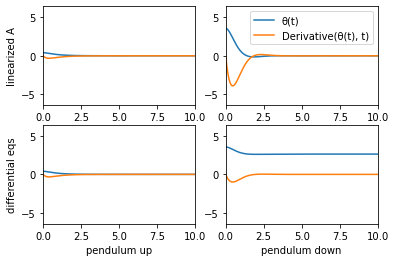

In [26]:
fig, axs = plt.subplots(2, 2)

for row, state in enumerate(states):
    axs[0, 0].plot(timeline, solution_up_lin_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[0, 1].plot(timeline, solution_down_lin_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 0].plot(timeline, solution_up_deq_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 1].plot(timeline, solution_down_deq_k[:, row], label=str(state))

for i in range(len(axs)):
    for j in range(len(axs[0])):
        axs[i,j].axis([-0.01, timeline[-1] + 0.01, -(math.pi * 2 + 0.1), math.pi * 2 + 0.1])

axs[0,1].legend()
axs[0,0].set_ylabel("linearized A")
axs[1,0].set_ylabel("differential eqs")
axs[1,0].set_xlabel("pendulum up")
axs[1,1].set_xlabel("pendulum down")

plt.plot()

print("Controlled Pendulum")

Controlled Pendulum (Zoom)


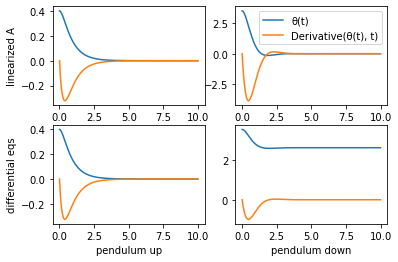

In [27]:
fig, axs = plt.subplots(2, 2)

for row, state in enumerate(states):
    axs[0, 0].plot(timeline, solution_up_lin_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[0, 1].plot(timeline, solution_down_lin_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 0].plot(timeline, solution_up_deq_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 1].plot(timeline, solution_down_deq_k[:, row], label=str(state))

axs[0,1].legend()
axs[0,0].set_ylabel("linearized A")
axs[1,0].set_ylabel("differential eqs")
axs[1,0].set_xlabel("pendulum up")
axs[1,1].set_xlabel("pendulum down")

plt.plot()

print("Controlled Pendulum (Zoom)")